In [3]:
!pip install kagglehub torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 852.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [6]:
# Move it to the correct location
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

100%|██████████| 395M/395M [00:08<00:00, 51.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


In [10]:
import os
print("Files in path:")
print(os.listdir(path))


Files in path:
['images']


In [11]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

image_path = os.path.join(path, "images")  # Correct subfolder

# Step 2: Dataset class
class AnimeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname)
                            for fname in os.listdir(root_dir)
                            if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

        print(f"✅ Found {len(self.image_paths)} images in {self.root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Step 3: Transform
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Step 4: Load
dataset = AnimeFaceDataset(image_path, transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


✅ Found 63565 images in /root/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3/images


In [13]:
import torch.nn as nn
class AnimeGenerator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0),  # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),    # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),    # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),     # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, img_channels, 4, 2, 1),  # 64x64
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z.view(z.size(0), z.size(1), 1, 1))


In [14]:
class AnimeDiscriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),     # 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),              # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),             # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1),             # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0),               # 1x1
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)


[0/497] Loss D: 1.3505 | Loss G: 1.7790
[50/497] Loss D: 0.3706 | Loss G: 3.5109
[100/497] Loss D: 0.8430 | Loss G: 4.8375
[150/497] Loss D: 0.6867 | Loss G: 3.8230
[200/497] Loss D: 0.6867 | Loss G: 4.6013
[250/497] Loss D: 0.4528 | Loss G: 2.4935
[300/497] Loss D: 0.6182 | Loss G: 9.2460
[350/497] Loss D: 0.6024 | Loss G: 5.9774
[400/497] Loss D: 0.5076 | Loss G: 4.2873
[450/497] Loss D: 0.4472 | Loss G: 4.1368
[0/497] Loss D: 0.5937 | Loss G: 3.7473
[50/497] Loss D: 0.3903 | Loss G: 4.1901
[100/497] Loss D: 0.4648 | Loss G: 4.9864
[150/497] Loss D: 1.0669 | Loss G: 2.5006
[200/497] Loss D: 0.8735 | Loss G: 7.7249
[250/497] Loss D: 0.5249 | Loss G: 4.0356
[300/497] Loss D: 0.3316 | Loss G: 4.8760
[350/497] Loss D: 0.7821 | Loss G: 10.0163
[400/497] Loss D: 0.7110 | Loss G: 3.3800
[450/497] Loss D: 0.4937 | Loss G: 7.2175
[0/497] Loss D: 0.4235 | Loss G: 6.3605
[50/497] Loss D: 0.2727 | Loss G: 2.7717
[100/497] Loss D: 0.3200 | Loss G: 4.9433
[150/497] Loss D: 0.4133 | Loss G: 5.2528


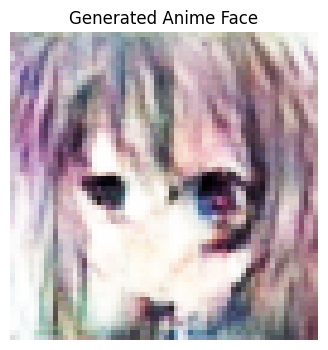

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Init models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = AnimeGenerator().to(device)
D = AnimeDiscriminator().to(device)

# Loss and optimizers
loss_fn = nn.BCELoss()
opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise for viewing generator output
fixed_noise = torch.randn(1, 100, device=device)

# Train loop
G.train()
D.train()
for epoch in range(10):
    for batch_idx, real_imgs in enumerate(loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # === Labels ===
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # === Train Discriminator ===
        noise = torch.randn(batch_size, 100, device=device)
        fake_imgs = G(noise).detach()

        D_real = D(real_imgs)
        D_fake = D(fake_imgs)

        loss_D_real = loss_fn(D_real, real_labels)
        loss_D_fake = loss_fn(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # === Train Generator ===
        noise = torch.randn(batch_size, 100, device=device)
        fake_imgs = G(noise)
        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        if batch_idx % 50 == 0:
            print(f"[{batch_idx}/{len(loader)}] Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

# === Show 1 sample image ===
G.eval()
with torch.no_grad():
    sample_img = G(fixed_noise).detach().cpu()
    sample_img = vutils.make_grid(sample_img, normalize=True)
    plt.figure(figsize=(4,4))
    plt.imshow(sample_img.permute(1, 2, 0))
    plt.title("Generated Anime Face")
    plt.axis("off")
    plt.show()
